# Astropy Remapping Testing (_values methods)
- Test how good the remapping of pixels (and constituent corners) is using the simple astropy pixel to world and world to pixel functions

In [221]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy import wcs
import astropy.wcs.utils as wcsutil
import astropy.units as u
import astropy.convolution as convolution
from astropy.coordinates import SkyCoord
import numpy as np
import sunpy.data.sample
import sunpy.map
from sunpy.coordinates import HeliographicCarrington, HeliographicStonyhurst, Heliocentric, Helioprojective, frames
from astropy.io import fits
import matplotlib.colors
from scipy import signal
from scipy import misc
import math
import json
import matplotlib as mpl
import sunpy.visualization.colormaps as cm
magmap = mpl.colormaps['hmimag']

### load HRT arlongterm test data - one on the first day of arlongterm, and one (later) on the last day

- blos and icnt

In [139]:
# 12-10-23

#load HRT first blos
filedir = '/data/solo/phi/data/fmdb/public/l2/2023-10-12/'
bfile = 'solo_L2_phi-hrt-blos_20231012T001503_V202408291137_0350120601.fits.gz'
icfile = 'solo_L2_phi-hrt-icnt_20231012T001503_V202408291137_0350120601.fits.gz'

hrt_121023_b = fits.getdata(filedir+bfile)
hrt_121023_b_hdr = fits.getheader(filedir+bfile)

hrt_121023_ic = fits.getdata(filedir+icfile)
hrt_121023_ic_hdr = fits.getheader(filedir+icfile)

print(hrt_121023_b_hdr['CRPIX1'])
print(hrt_121023_b_hdr['CRPIX2'])
print(hrt_121023_b_hdr['CRVAL1'])
print(hrt_121023_b_hdr['CRVAL2'])

1109.117
755.6157
338.6472
387.539


### correct the WCS keywords

In [140]:
#load 12-10-23 wcs correction
with open('/data/slam/sinjan/arlongterm_hrt_wcs_corr/hrt_CRVAL_corrections_20231012.json') as f:
    hrt_121023_wcs_err = json.load(f)

In [141]:
fileDID = hrt_121023_b_hdr['PHIDATID']

In [142]:
crval_err = hrt_121023_wcs_err[fileDID]

In [143]:
crval_err

[-1.934214925750382, 113.7871115449891]

In [144]:
hrt_121023_b_hdr['CRVAL1']

338.6472

In [145]:
#correct CRVAL keywords
crval_errx = crval_err[0]
crval_erry = crval_err[1]

hrt_121023_b_hdr['CRVAL1'] = hrt_121023_b_hdr['CRVAL1']-crval_errx
hrt_121023_b_hdr['CRVAL2'] = hrt_121023_b_hdr['CRVAL2']-crval_erry

hrt_121023_ic_hdr['CRVAL1'] = hrt_121023_ic_hdr['CRVAL1']-crval_errx
hrt_121023_ic_hdr['CRVAL2'] = hrt_121023_ic_hdr['CRVAL2']-crval_erry

In [146]:
hrt_121023_bm = sunpy.map.Map(filedir+bfile)
hrt_121023_bm.reference_coordinate

<SkyCoord (Helioprojective: obstime=2023-10-12T00:15:03.293, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2023-10-12T00:15:03.293, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-78.266917, 1.8157965, 4.66449761e+10)>): (Tx, Ty) in arcsec
    (338.6472, 387.539)>

In [147]:
crval_errx_arcsec=-crval_errx*u.arcsec
crval_erry_arcsec=-crval_erry*u.arcsec
hrt_121023_bm=hrt_121023_bm.shift_reference_coord(crval_errx_arcsec.to(u.deg),crval_erry_arcsec.to(u.deg))
print("Added items:", hrt_121023_bm.meta.added_items)
print("Removed items:", hrt_121023_bm.meta.removed_items)
print("Modified items:", hrt_121023_bm.meta.modified_items)

Added items: {}
Removed items: {}
Modified items: {'crval1': (original=338.6472, current=340.5814149257504), 'crval2': (original=387.539, current=273.7518884550109)}


In [148]:
hrt_121023_bm.reference_coordinate

<SkyCoord (Helioprojective: obstime=2023-10-12T00:15:03.293, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2023-10-12T00:15:03.293, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-78.266917, 1.8157965, 4.66449761e+10)>): (Tx, Ty) in arcsec
    (340.58141493, 273.75188846)>

### load the HMI file (blos and ic_45s)

In [149]:
hmifiledir = '/scratch/slam/sinjan/arlongterm_hmi/'
hmibfile = 'blos_45/hmi.m_45s.20231012_002145_TAI.2.magnetogram.fits'
hmiicfile = 'ic_45/hmi.ic_45s.20231012_002145_TAI.2.continuum.fits'

#must rotate the HMI files
hmi_121023_b = sunpy.map.Map(hmifiledir+hmibfile).rotate()
hmi_121023_b_hdr = hmi_121023_b.meta

hmi_121023_ic = sunpy.map.Map(hmifiledir+hmiicfile).rotate()
hmi_121023_ic_hdr = hmi_121023_ic.meta

### plot both to confirm

In [150]:
hpc_coords = sunpy.map.all_coordinates_from_map(hmi_121023_b)
mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)

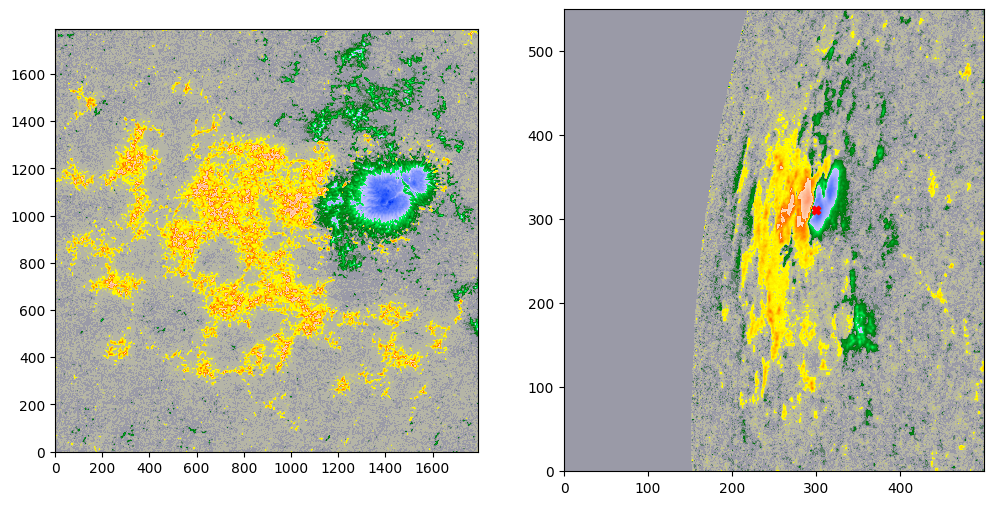

In [151]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(hrt_121023_b,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)

plt.subplot(122)
hmi_121023_b.data[np.isnan(hmi_121023_b.data)]=0
plt.imshow(hmi_121023_b.data[2000:2550,:500]*~mask[2000:2550,:500],origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
plt.scatter(300,310,marker='X',color='red')
plt.show()

In [72]:
x_hmi=300
y_hmi=2310

In [152]:
neighbour_length = 1
x = range(x_hmi-neighbour_length,x_hmi+neighbour_length+1)
y = range(y_hmi-neighbour_length,y_hmi+neighbour_length+1)

X,Y = np.meshgrid(x,y)
print(X)
print(Y)

[[299 300 301]
 [299 300 301]
 [299 300 301]]
[[2309 2309 2309]
 [2310 2310 2310]
 [2311 2311 2311]]


In [167]:
central_coord_hmi = hmi_121023_b.wcs.pixel_to_world_values(X,Y)
# bottom_left_coord_hmi = hmi_121023_b.pixel_to_world_values((x_hmi - 0.5) * u.pixel, (y_hmi - 0.5) * u.pixel)
# top_right_coord_hmi = hmi_121023_b.pixel_to_world_values((x_hmi + 0.5) * u.pixel, (y_hmi + 0.5) * u.pixel)

In [168]:
central_coord_hmi

(array([[359.75360796, 359.75374797, 359.75388798],
        [359.75360796, 359.75374797, 359.75388798],
        [359.75360796, 359.75374797, 359.75388798]]),
 array([[0.03648418, 0.03648418, 0.03648418],
        [0.03662418, 0.03662419, 0.03662419],
        [0.03676419, 0.03676419, 0.03676419]]))

In [169]:
hrt_121023_bm.wcs.world_to_pixel_values(central_coord_hmi[0],central_coord_hmi[1])

(array([[-1363.04690805, -1362.04810972, -1361.0493114 ],
        [-1362.91032036, -1361.91152203, -1360.91272371],
        [-1362.77373266, -1361.77493434, -1360.77613602]]),
 array([[805.0719847 , 804.93540269, 804.79882068],
        [806.07077368, 805.93419167, 805.79760966],
        [807.06956265, 806.93298064, 806.79639862]]))

In [184]:
print(hrt_121023_b_hdrn['CROTA'])

print(np.cos(np.deg2rad(7.786629573231)))
print(-np.sin(np.deg2rad(7.786629573231)))
print(np.sin(np.deg2rad(7.786629573231)))
print(np.cos(np.deg2rad(7.786629573231)))

7.786629573231
0.9907794838055178
-0.1354843698367885
0.1354843698367885
0.9907794838055178


In [182]:
crpix_errx = 27
crpix_erry = 226
crval_errx = -1.934214925750382
crval_erry = 113.7871115449891

hrt_121023_b_hdrn = fits.getheader(filedir+file)

hrt_121023_b_hdrn['CRPIX1'] = hrt_121023_b_hdrn['CRPIX1']-crpix_errx
hrt_121023_b_hdrn['CRPIX2'] = hrt_121023_b_hdrn['CRPIX2']-crpix_erry
hrt_121023_b_hdrn['CRVAL1'] = hrt_121023_b_hdrn['CRVAL1']-crval_errx
hrt_121023_b_hdrn['CRVAL2'] = hrt_121023_b_hdrn['CRVAL2']-crval_erry
hrt_121023_b_hdrn['PC1_1'] = np.cos(np.deg2rad(hrt_121023_b_hdrn['CROTA']))
hrt_121023_b_hdrn['PC1_2'] = -np.sin(np.deg2rad(hrt_121023_b_hdrn['CROTA']))
hrt_121023_b_hdrn['PC2_1'] = np.sin(np.deg2rad(hrt_121023_b_hdrn['CROTA']))
hrt_121023_b_hdrn['PC2_2'] = np.cos(np.deg2rad(hrt_121023_b_hdrn['CROTA']))

test = WCS(hrt_121023_b_hdrn)
test

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 
CRVAL : 0.09460594859048621 0.07604219123750303 
CRPIX : 1082.117 529.6157 
PC1_1 PC1_2  : 0.9907794838055178 -0.1354843698367885 
PC2_1 PC2_2  : 0.1354843698367885 0.9907794838055178 
CDELT : 0.0001388888888888889 0.0001388888888888889 
NAXIS : 1792  1792

In [174]:
hrt_121023_bm.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 
CRVAL : 0.094605948590486 0.076042191237503 
CRPIX : 1109.117 755.6157 
PC1_1 PC1_2  : 0.9907795 -0.1354844 
PC2_1 PC2_2  : 0.1354844 0.9907795 
CDELT : 0.00013888888888889 0.00013888888888889 
NAXIS : 1792  1792

In [189]:
import astropy.wcs.utils as wcsutil

In [211]:
out=wcsutil.pixel_to_skycoord(X,Y,hmi_121023_b.wcs)

In [212]:
out

<SkyCoord (Helioprojective: obstime=2023-10-12T00:20:44.600, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2023-10-12T00:20:44.600, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01817826, 6.12642574, 1.49338581e+11)>): (Tx, Ty) in arcsec
    [[(-887.01133743, 131.34303148), (-886.50730847, 131.34303286),
      (-886.0032795 , 131.34303424)],
     [(-887.01133743, 131.84706489), (-886.50730847, 131.84706627),
      (-886.0032795 , 131.84706766)],
     [(-887.01133743, 132.35109829), (-886.50730847, 132.35109968),
      (-886.0032795 , 132.35110107)]]>

In [214]:
out2=wcsutil.skycoord_to_pixel(out,hrt_121023_bm.wcs)
out2

(array([[1427.83398472, 1436.66504324, 1445.46119496],
        [1426.72167243, 1435.55724325, 1444.357855  ],
        [1425.60403224, 1434.44414005, 1443.24923621]]),
 array([[1063.73952892, 1063.47036218, 1063.20236437],
        [1067.04818329, 1066.77883282, 1066.51065307],
        [1070.35701874, 1070.08748372, 1069.8191212 ]]))

In [215]:
def get_phi_pixels(x_hmi,y_hmi,neighbour_length,hmi_map,hrt_map):
    x = range(x_hmi-neighbour_length,x_hmi+neighbour_length+1)
    y = range(y_hmi-neighbour_length,y_hmi+neighbour_length+1)

    X,Y = np.meshgrid(x,y)
    out=wcsutil.pixel_to_skycoord(X,Y,hmi_map.wcs)
    return wcsutil.skycoord_to_pixel(out,hrt_map.wcs)

In [ ]:
#time it

In [218]:
import datetime

start_time = datetime.datetime.now()

phi_out_test_100 = get_phi_pixels(300,2310,4,hmi_121023_b,hrt_121023_bm)
print(phi_out_test_100[0].size)

end_time = datetime.datetime.now()

print('Time taken: ', (end_time-start_time))

81
Time taken:  0:00:00.031485


In [219]:
import datetime

start_time = datetime.datetime.now()

phi_out_test_100 = get_phi_pixels(300,2310,16,hmi_121023_b,hrt_121023_bm)
print(phi_out_test_100[0].size)

end_time = datetime.datetime.now()

print('Time taken: ', (end_time-start_time))

1089
Time taken:  0:00:00.027813


In [220]:
# now make a nice function that does the corners of each pixel, and creates a dict like for pixel_remap_explore
# time it

# much later
# decide how to combine pixels within these regions, and any gaps between overlaps

In [225]:
def get_phi_pixel_array_from_hmi_pixel_array(X,Y,hmi_map,hrt_map):
    out=wcsutil.pixel_to_skycoord(X,Y,hmi_map.wcs)
    return wcsutil.skycoord_to_pixel(out,hrt_map.wcs)

In [222]:
X

array([[299, 300, 301],
       [299, 300, 301],
       [299, 300, 301]])

In [266]:
def get_phi_bleft_tright_from_hmi_pixel_array(X,Y,hmi_map,hrt_map):
    bleft_X = X - 0.5
    bleft_Y = Y - 0.5
    tright_X = X + 0.5
    tright_Y = Y + 0.5

    bleft_phi = get_phi_pixel_array_from_hmi_pixel_array(bleft_X,bleft_Y,hmi_map,hrt_map)
    tright_phi = get_phi_pixel_array_from_hmi_pixel_array(tright_X,tright_Y,hmi_map,hrt_map)

    return bleft_phi,tright_phi

In [228]:
start_time = datetime.datetime.now()

x=range(0,500)
y=range(2000,2500)
X,Y=np.meshgrid(x,y)

phi_out_test = get_phi_bleft_tright_from_hmi_pixel_array(X,Y,hmi_121023_b,hrt_121023_bm)
print(len(phi_out_test[0]))

end_time = datetime.datetime.now()

print('Time taken: ', (end_time-start_time))

2
Time taken:  0:00:00.302049


In [285]:
def plot_bleft_tright_phi_and_hmi(bleft_phi,tright_phi,X,Y,hmi_map,phi_map):
    hmi_pixels = list(zip(X.flatten(),Y.flatten()))
    
    min_x_hmi_lim = np.min(X)-5
    max_x_hmi_lim = np.max(X)+5

    min_y_hmi_lim = np.min(Y)-5
    max_y_hmi_lim = np.max(Y)+5

    plt.figure(figsize=(12,20))
    plt.subplot(211)
    hmi_map.data[np.isnan(hmi_map.data)]=0
    
    hpc_coords = sunpy.map.all_coordinates_from_map(hmi_map)
    mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)
        
    im=plt.imshow(hmi_map.data*~mask,origin="lower",cmap=magmap,vmin=-2000,vmax=2000) #[2000:2550,:500]
    plt.colorbar(im)
    plt.ylim(min_y_hmi_lim,max_y_hmi_lim)
    plt.xlim(min_x_hmi_lim,max_x_hmi_lim)
    for pix in hmi_pixels:
        plt.scatter(pix[0],pix[1],marker='X',s=10)
    drms_id = hmi_map.meta['drms_id']
    plt.title(f'{drms_id} - {hmi_map.date}')

    plt.subplot(212)
    im2=plt.imshow(phi_map.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)

    ax=plt.gca()

    blkxs,blkys = bleft_phi
    trkxs,trkys = tright_phi

    blkxs=blkxs.flatten()
    blkys=blkys.flatten()
    trkxs=trkxs.flatten()
    trkys=trkys.flatten()
    
    for i in range(X.size):
        blx,bly = blkxs[i],blkys[i]
        trx,tryy = trkxs[i],trkys[i]
        
        rect = patches.Rectangle((blx, bly), trx-blx, tryy-bly, linewidth=1, facecolor='none', edgecolor='black')
        ax.add_patch(rect)

        centrex = blx + (trx-blx)/2 # obviously use a different formula for different shapes
        centrey = bly + (tryy-bly)/2
        plt.text(centrex, centrey,f'{hmi_pixels[i]}',horizontalalignment = 'center',verticalalignment = 'center')

    phi_x_min_lim = np.min(bleft_phi[0].flatten())-10
    phi_x_max_lim = np.max(tright_phi[0].flatten())+10

    phi_y_min_lim = np.min(bleft_phi[1])-10
    phi_y_max_lim = np.max(tright_phi[1])+10

    plt.xlim(phi_x_min_lim,phi_x_max_lim)
    plt.ylim(phi_y_min_lim,phi_y_max_lim)
    filename = phi_map.meta['filename']
    plt.title(f'{filename} - {phi_map.date}')
    plt.colorbar(im2,fraction=0.036)
    plt.suptitle('Pixel remap')
    plt.tight_layout()
    plt.show()

In [289]:
x=range(299,302)
y=range(2309,2312)
X,Y=np.meshgrid(x,y)

bleft_phi,tright_phi = get_phi_bleft_tright_from_hmi_pixel_array(X,Y,hmi_121023_b,hrt_121023_bm)

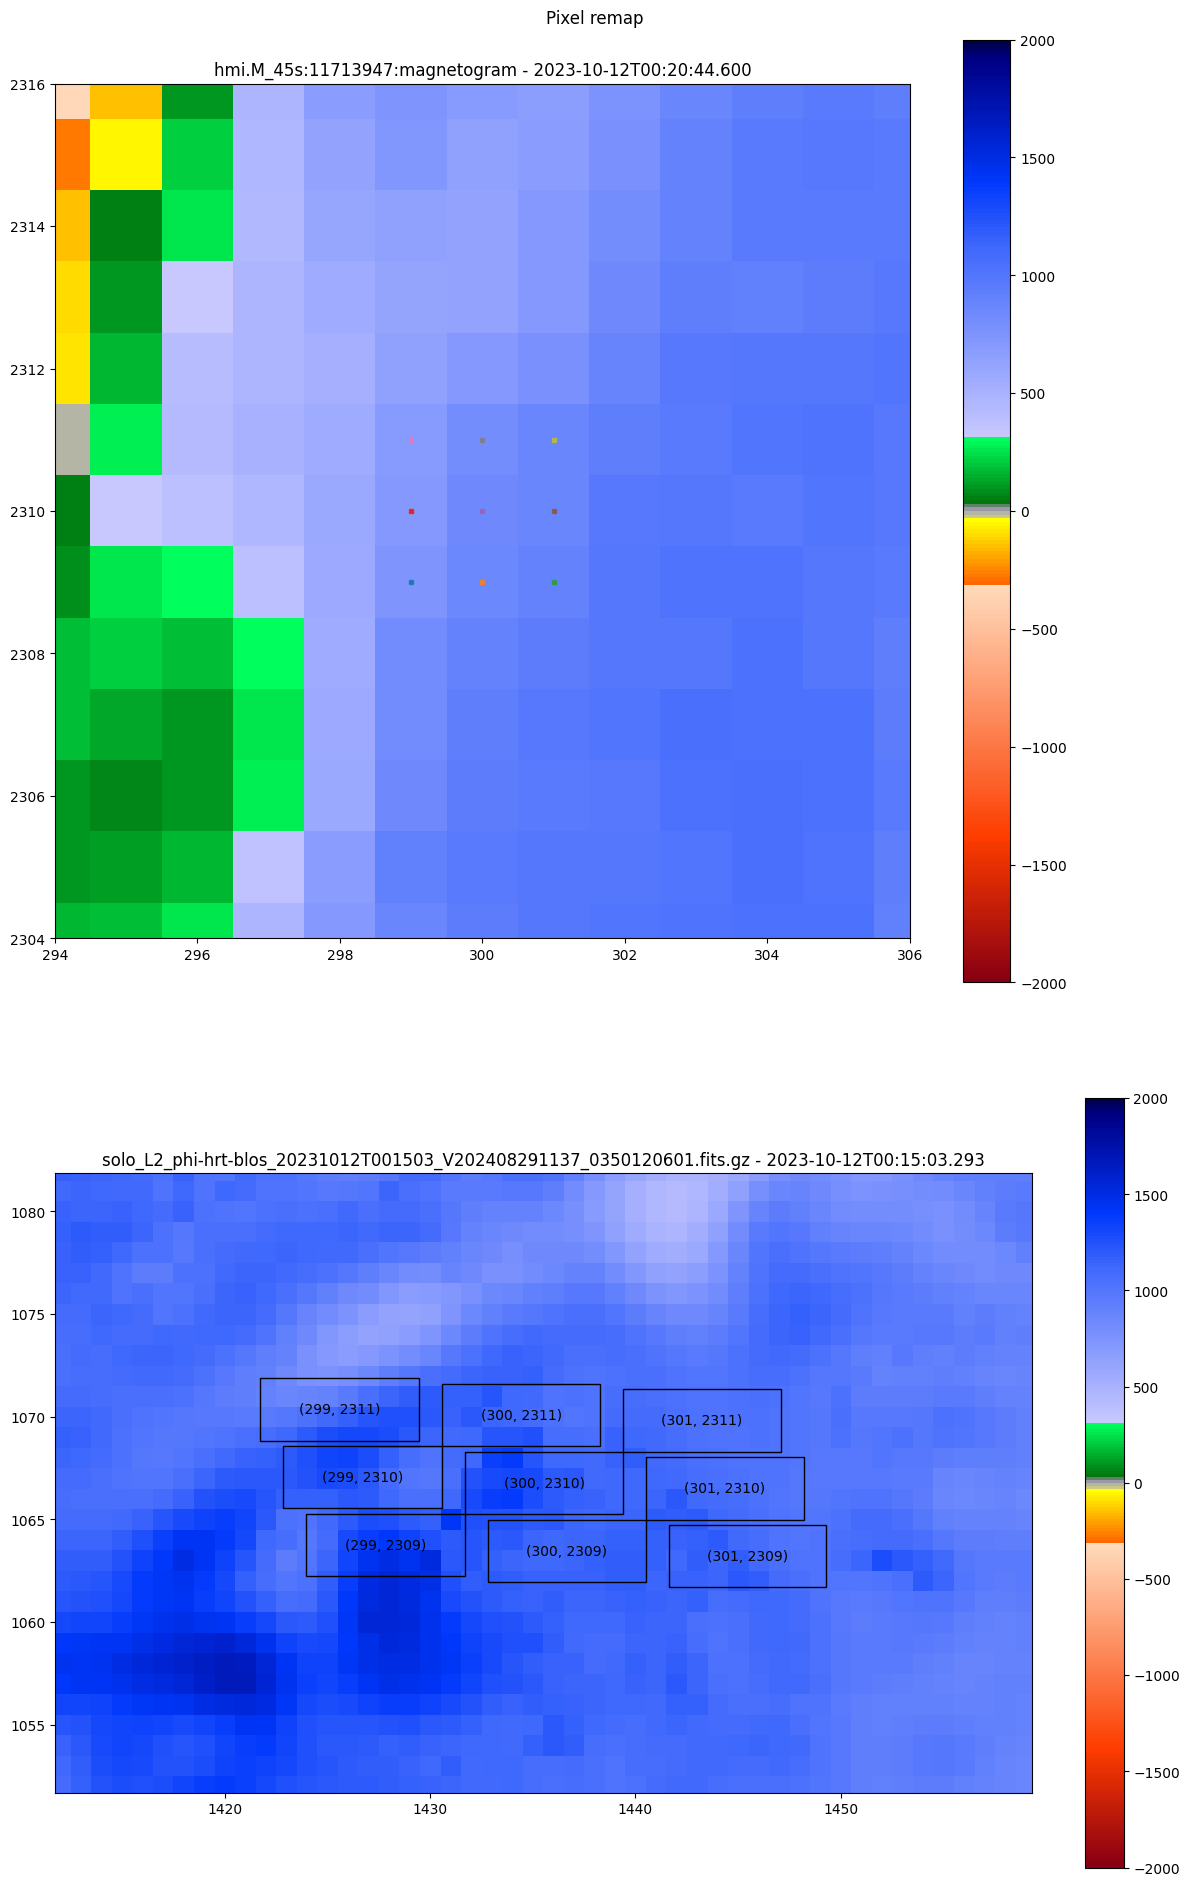

In [290]:
plot_bleft_tright_phi_and_hmi(bleft_phi,tright_phi,X,Y,hmi_121023_b,hrt_121023_bm)

In [292]:
print(bleft_phi)
print(tright_phi)

(array([[1423.96053815, 1432.80693574, 1441.6182587 ],
       [1422.84861691, 1431.69954063, 1440.51533744],
       [1421.73135947, 1430.58683445, 1439.40712951]]), array([[1062.22024922, 1061.95058514, 1061.68209558],
       [1065.52890549, 1065.2590572 , 1064.99038523],
       [1068.83774311, 1068.56770977, 1068.29885456]]))
(array([[1431.69954063, 1440.51533744, 1449.2963939 ],
       [1430.58683445, 1439.40712951, 1448.19263223],
       [1429.46880824, 1438.29362622, 1447.08359974]]), array([[1065.2590572 , 1064.99038523, 1064.72287663],
       [1068.56770977, 1068.29885456, 1068.03116449],
       [1071.87654318, 1071.60750389, 1071.33963152]]))


In [287]:
x=range(297,304)
y=range(2307,2314)
X,Y=np.meshgrid(x,y)

bleft_phi,tright_phi = get_phi_bleft_tright_from_hmi_pixel_array(X,Y,hmi_121023_b,hrt_121023_bm)

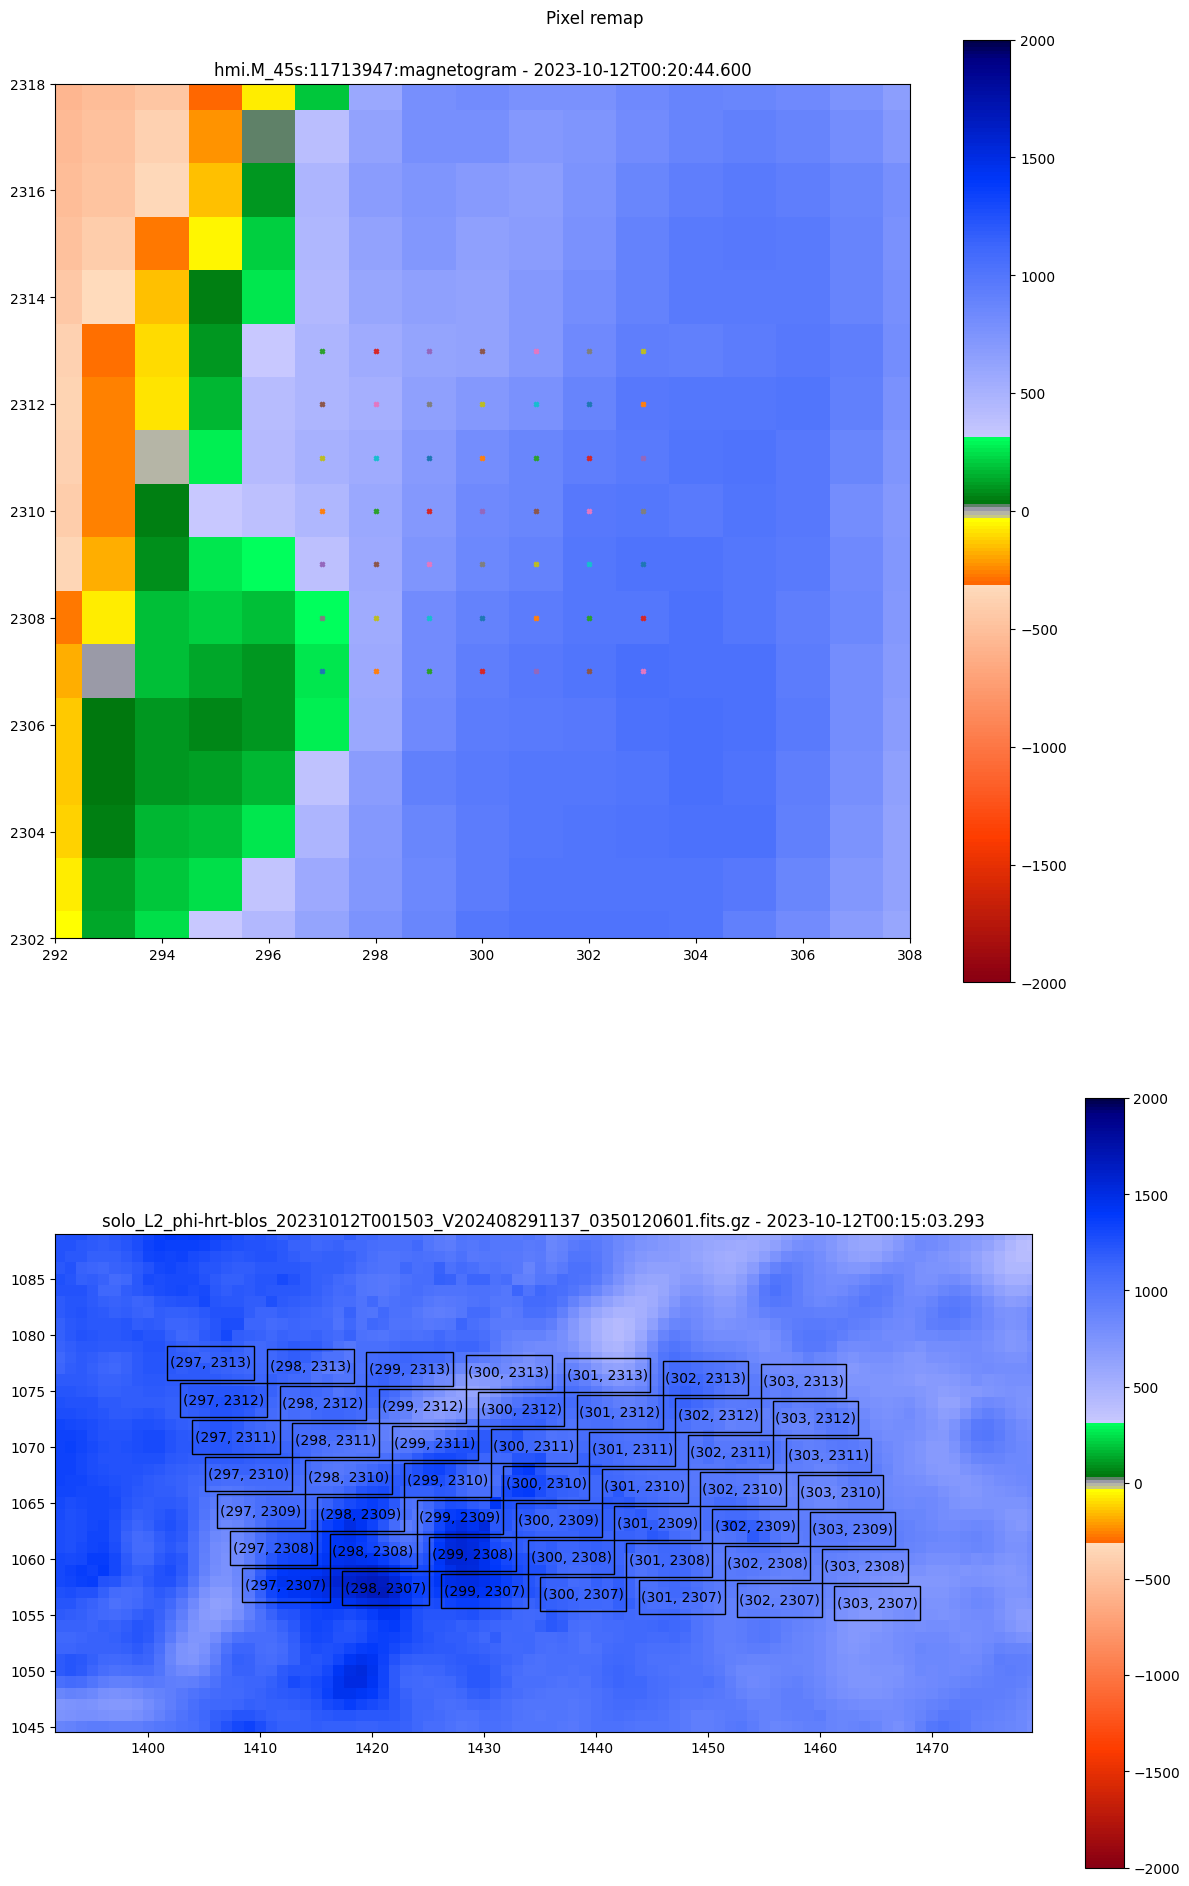

In [288]:
plot_bleft_tright_phi_and_hmi(bleft_phi,tright_phi,X,Y,hmi_121023_b,hrt_121023_bm)